# Data Set-

Kaggle - https://www.kaggle.com/datasets/msambare/fer2013
The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)


# Setting up Kaggle Directory

In [ ]:
!mkdir -p ./kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot create regular file '/root/.kaggle/': Not a directory


In [ ]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 80% 48.0M/60.3M [00:00<00:00, 182MB/s]
100% 60.3M/60.3M [00:00<00:00, 183MB/s]


In [ ]:
!unzip /content/fer2013.zip -d /content/

# Installing Packages

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import  ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model

# Setting up Directory to save model data.

In [ ]:
os.makedirs('test_dir', exist_ok=True)

In [ ]:
# Define your project name
project_name = 'FER_2013_Emotion_Detection'

# List your models
model_names = [
    'ResNet50_Transfer_Learning'
]

# Base directory (in this case, your Google Colab workspace)
base_dir = '/content/'

# Create the project directory
project_dir = os.path.join(base_dir, project_name)
os.makedirs(project_dir, exist_ok=True)

# Create a subdirectory for each model
for each_model in model_names:
    model_dir = os.path.join(project_dir, each_model)
    os.makedirs(model_dir, exist_ok=True)
    # Example subdirectories for model-related files
    # os.makedirs(os.path.join(model_dir, 'checkpoints'), exist_ok=True)
    # os.makedirs(os.path.join(model_dir, 'logs'), exist_ok=True)
    # os.makedirs(os.path.join(model_dir, 'saved_models'), exist_ok=True)

print(f'Project directory structure created at: {project_dir}')


Project directory structure created at: /content/FER_2013_Emotion_Detection


# Data Cleaning

In [ ]:
# Define the list of acceptable image extensions
image_exts = ['jpeg', 'jpg', 'png']

# Path to the directory containing image classes and possibly other nested subdirectories
data_dir = '/content/train'

# Walk through all directories and files in the dataset
for root, dirs, files in os.walk(data_dir):
    for file in files:
        # Construct the path to the current file
        file_path = os.path.join(root, file)

        try:
            # Check the file type of the current file
            file_type = imghdr.what(file_path)

            # If the file extension is not in the allowed list, remove it
            if file_type not in image_exts:
                print(f'Image not in ext list {file_path}')
                os.remove(file_path)
            else:
                # Proceed to process the image if needed, for example, reading it with OpenCV
                img = cv2.imread(file_path)

        except Exception as e:
            # Print out the issue and the path of the problematic file
            print(f'Issue with file {file_path}. Error: {e}')
            # Optionally, remove files that cause exceptions
            os.remove(file_path)

# Data Analysis

In [ ]:
# Define a function to count the number of files (assumed to be images for this context) for each subdirectory in a given directory.
# The function returns a DataFrame with these counts, indexed by a specified set name (e.g., 'train' or 'test').
def count_files_in_subdirs(directory, set_name):
    # Initialize an empty dictionary to hold the count of files for each subdirectory.
    counts = {}

    # Iterate over each item in the given directory.
    for item in os.listdir(directory):
        # Construct the full path to the item.
        item_path = os.path.join(directory, item)

        # Check if the item is a directory.
        if os.path.isdir(item_path):
            # Count the number of files in the subdirectory and add it to the dictionary.
            counts[item] = len(os.listdir(item_path))

    # Convert the counts dictionary to a DataFrame for easy viewing and analysis.
    # The index of the DataFrame is set to the provided set name.
    df = pd.DataFrame(counts, index=[set_name])
    return df

# Paths to the training and testing directories.
train_dir = '/content/train'
test_dir = '/content/test'

# Count the files in the subdirectories of the training directory and print the result.
train_count = count_files_in_subdirs(train_dir, 'train')
print(train_count)

# Count the files in the subdirectories of the testing directory and print the result.
test_count = count_files_in_subdirs(test_dir, 'test')
print(test_count)


        sad  fear  happy  disgust  neutral  angry  surprise
train  4830  4097   7215      436     4965   3995      3171
       sad  fear  happy  disgust  neutral  angry  surprise
test  1247  1024   1774      111     1233    958       831


<Axes: >

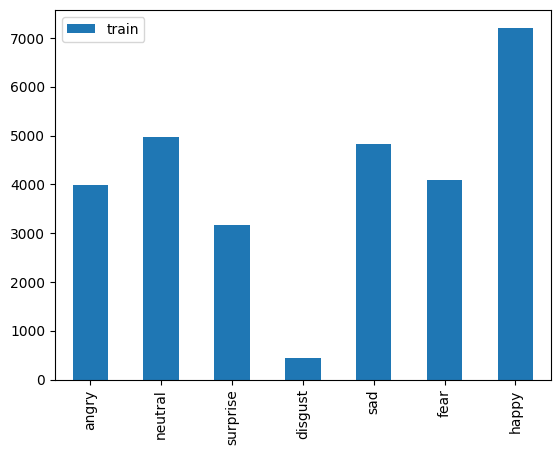

In [ ]:
train_count.transpose().plot(kind='bar')

<Axes: >

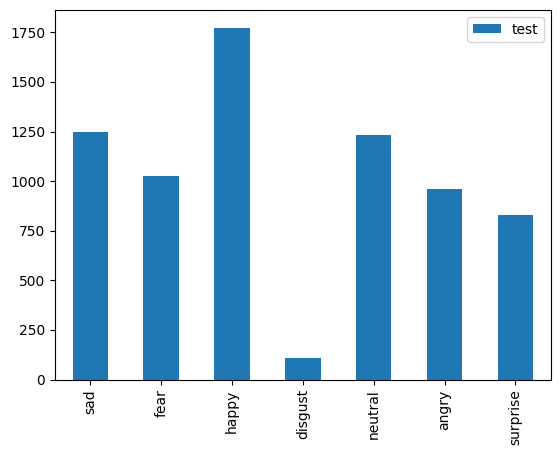

In [ ]:
test_count.transpose().plot(kind='bar')

# Plotting one image from each emotion.

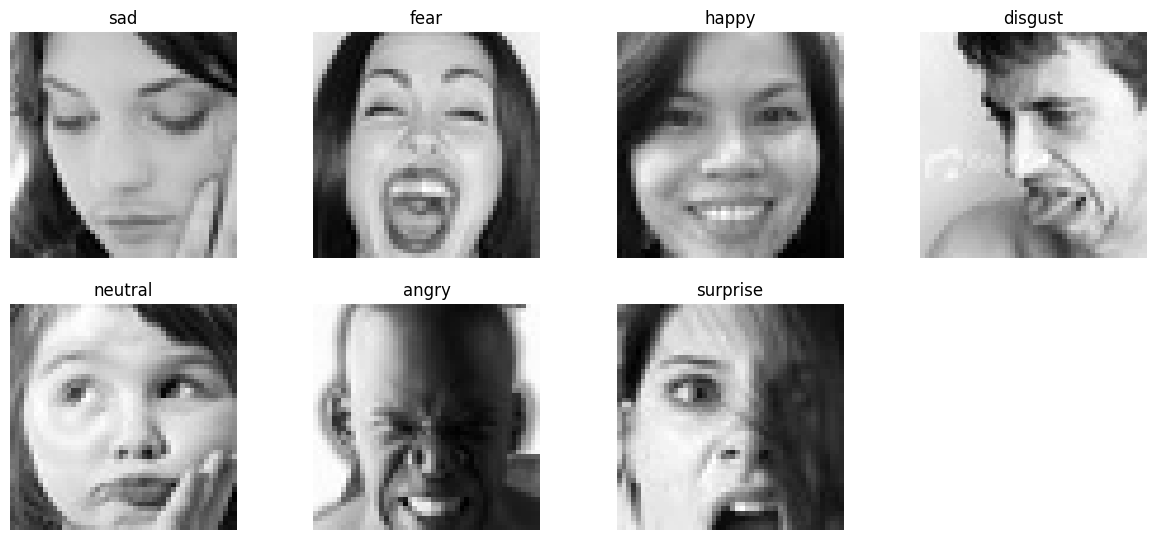

In [ ]:
emotions = os.listdir(train_dir)
plt.figure(figsize=(15,10))

for i, emotion in enumerate(emotions, 1):
    folder = os.path.join(train_dir, emotion)
    img_path = os.path.join(folder, os.listdir(folder)[42])
    img = plt.imread(img_path)
    plt.subplot(3, 4, i)
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')

# Plotting random images from given directory

In [ ]:
def plot_images_from_directory(directory_path, class_name, num_images=9):
    # Retrieve list of all file names in the directory
    image_filenames = os.listdir(directory_path)

    # If there are fewer images than requested, we'll just show them all
    if len(image_filenames) < num_images:
        print(f"Only found {len(image_filenames)} images in {directory_path}, displaying them all.")
        num_images = len(image_filenames)

    # Randomly select 'num_images' number of file names
    selected_images = random.sample(image_filenames, num_images)

    # Plotting the images
    fig, axes = plt.subplots(3, 3, figsize=(5, 5))  # Adjust the size as needed
    axes = axes.ravel()

    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(directory_path, image_file)
        # image = Image.open(image_path)
        image = load_img(image_path)
        axes[i].imshow(image)
        axes[i].set_title(f"Image: {class_name}")
        axes[i].axis('off')  # Hide the axis

    plt.tight_layout()
    plt.show()

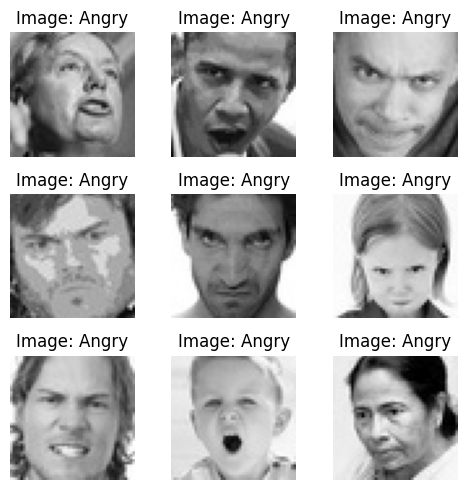

In [ ]:
# Placeholder for the directory path
angry_directory_path = '/content/train/angry'  # Replace with your directory path
plot_images_from_directory(angry_directory_path, class_name = 'Angry')

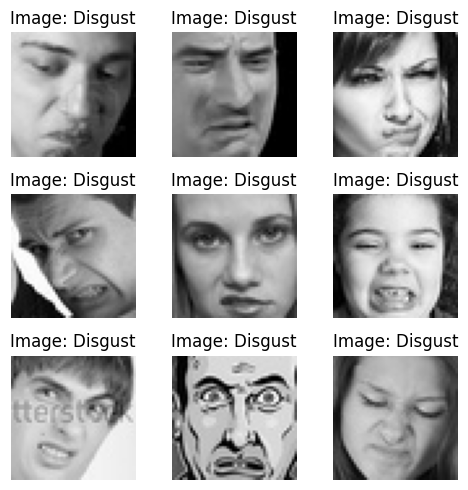

In [ ]:
# Placeholder for the directory path
disgust_directory_path = '/content/train/disgust'  # Replace with your directory path
plot_images_from_directory(disgust_directory_path, class_name = 'Disgust')

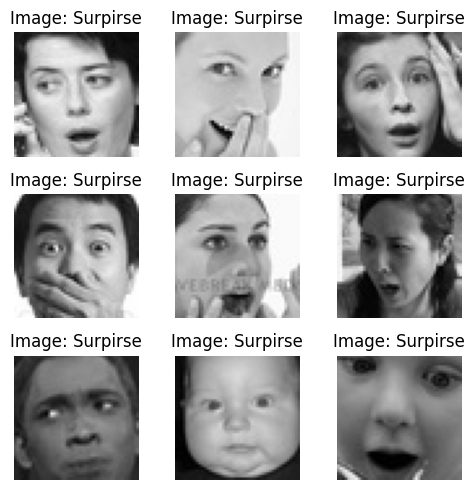

In [ ]:
# Placeholder for the directory path
surpirse_directory_path = '/content/train/surprise'  # Replace with your directory path
plot_images_from_directory(surpirse_directory_path, class_name = 'Surpirse')

# Checking shapes and channels.

In [ ]:
image = '/content/train/angry/Training_10118481.jpg'

import cv2

img = cv2.imread(image) # Default load in color format.

# If the image is loaded successfully, print its pixel values
if img is not None:
    # print(img)
    print("Shape:", img.shape)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (48, 48, 3)


# Model 4 : Transfer Leanring - ResNet50

In [ ]:
# Directory paths for training and testing data
train_dir = '/content/train'
test_dir = '/content/test'

# Batch size for data generators
batch_size = 64

# Data augmentation configuration for training data
train_datagen = ImageDataGenerator(
                                  rescale=1 / 255.,  # Rescale pixel values to [0,1]
                                  rotation_range=10,  # Random rotation within range [-10,10] degrees
                                  zoom_range=0.2,  # Random zoom between [0.8, 1.2]
                                  width_shift_range=0.1,  # Random horizontal shift within range [-0.1, 0.1]
                                  height_shift_range=0.1,  # Random vertical shift within range [-0.1, 0.1]
                                  horizontal_flip=True,  # Random horizontal flip
                                  fill_mode='nearest'  # Fill mode for handling newly created pixels
                                 )

# Configuration for testing data (only rescaling)
test_datagen = ImageDataGenerator(
                                  rescale=1 / 255.  # Rescale pixel values to [0,1]
                                 )

# Data generators for training and testing data
train_generator = train_datagen.flow_from_directory(
                                                    train_dir,  # Directory containing training data
                                                    class_mode="categorical",  # Classification mode for categorical labels
                                                    target_size=(224, 224),  # Resize input images to (224,224)
                                                    color_mode='rgb',  # Color mode for images (RGB)
                                                    shuffle=True,  # Shuffle training data
                                                    batch_size=batch_size,  # Batch size for training
                                                    subset='training'  # Subset of data (training)
                                                   )

test_generator = test_datagen.flow_from_directory(
                                                  test_dir,  # Directory containing testing data
                                                  class_mode="categorical",  # Classification mode for categorical labels
                                                  target_size=(224, 224),  # Resize input images to (224,224)
                                                  color_mode="rgb",  # Color mode for images (RGB)
                                                  shuffle=False,  # Do not shuffle testing data
                                                  batch_size=batch_size  # Batch size for testing
                                                 )


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Introducing Class wieghts for imbalanced data

In [ ]:
# Extract class labels for all instances in the training dataset
classes = np.array(train_generator.classes)

# Calculate class weights to handle imbalances in the training data
# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
class_weights = compute_class_weight(
    class_weight='balanced',  # Strategy to balance classes
    classes=np.unique(classes),  # Unique class labels
    y=classes  # Class labels for each instance in the training dataset
)

# Create a dictionary mapping class indices to their calculated weights
class_weights_dict = dict(enumerate(class_weights))

# Output the class weights dictionary
print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


# PREVIUOUS


In [ ]:
ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3),
                                               include_top= False,
                                               weights='imagenet'
                                               )

94668760/94668760 [==============================] - 1s 0us/step


In [ ]:
# Freezing all layers except last 50

ResNet50V2.trainable = True

for layer in ResNet50V2.layers[:-50]:
    layer.trainable = False

In [ ]:
def Create_ResNet50V2_Model():

    model = Sequential([
                      ResNet50V2,
                      Dropout(0.25),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='relu'),
                      BatchNormalization(),
                      Dropout(0.5),
                      Dense(7,activation='softmax')
                    ])
    return model

In [ ]:
model = Create_ResNet50V2_Model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                                 
 batch_normalization (Batch  (None, 7, 7, 2048)        8192      
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 64)                6422592   
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                       

# continuation

In [ ]:
from tensorflow.keras.metrics import Accuracy,CategoricalAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy

In [ ]:
metrics = [TruePositives(name='tp'),FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
                CategoricalAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]


In [ ]:
# File path for the model checkpoint
cnn_path = '/content/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning'


# Callback to save the model checkpoint

checkpoint_callback = ModelCheckpoint(
    'best_weights',
    monitor='val_accuracy',
    mode = 'max',
    verbose=1,
    save_best_only=True,

    )

# Callback for early stopping
earlystop = EarlyStopping(monitor = 'val_accuracy',
                          patience = 7,
                          restore_best_weights = True,
                          verbose=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=2,
#                             min_lr=0.00005,
                              verbose=1)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
# callbacks = [checkpoint_callback, earlystop, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
# validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [ ]:
test_generator.batch_size

64

In [ ]:
test_steps_epoch

113

## Previous Training--22 epochs

In [ ]:
# train_history = model.fit(
#                           train_generator,
#                           steps_per_epoch=420,
#                           epochs=100,
#                           validation_data=test_generator,
#                           validation_steps=test_steps_epoch,
#                           class_weight=class_weights_dict,
#                           callbacks = callbacks_list
#                          )

Epoch 1/100


420/420 [==============================] - ETA: 0s - loss: 1.9391 - tp: 3615.0000 - fp: 2908.0000 - tn: 158210.0000 - fn: 23238.0000 - accuracy: 0.3251 - precision: 0.5542 - recall: 0.1346 - auc: 0.7024
Epoch 1: val_accuracy improved from -inf to 0.32544, saving model to best_weights
113/113 [==============================] - 25s 222ms/step
Failed to log precision recall curve:  multiclass format is not supported


/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



2/2 [==============================] - 0s 106ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20240512_083624-kiaj1f4u/files/model-best)... Done. 1.6s


420/420 [==============================] - 648s 1s/step - loss: 1.9391 - tp: 3615.0000 - fp: 2908.0000 - tn: 158210.0000 - fn: 23238.0000 - accuracy: 0.3251 - precision: 0.5542 - recall: 0.1346 - auc: 0.7024 - val_loss: 2.7345 - val_tp: 1088.0000 - val_fp: 1351.0000 - val_tn: 41717.0000 - val_fn: 6090.0000 - val_accuracy: 0.3254 - val_precision: 0.4461 - val_recall: 0.1516 - val_auc: 0.6963
Epoch 2/100
420/420 [==============================] - ETA: 0s - loss: 1.5892 - tp: 5859.0000 - fp: 2968.0000 - tn: 158150.0000 - fn: 20994.0000 - accuracy: 0.4460 - precision: 0.6638 - recall: 0.2182 - auc: 0.7994
Epoch 2: val_accuracy improved from 0.32544 to 0.53427, saving model to best_weights
113/113 [==============================] - 25s 221ms/step
Failed to log precision recall curve:  multiclass format is not supported


/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



2/2 [==============================] - 0s 107ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20240512_083624-kiaj1f4u/files/model-best)... Done. 5.0s


420/420 [==============================] - 621s 1s/step - loss: 1.5892 - tp: 5859.0000 - fp: 2968.0000 - tn: 158150.0000 - fn: 20994.0000 - accuracy: 0.4460 - precision: 0.6638 - recall: 0.2182 - auc: 0.7994 - val_loss: 1.2968 - val_tp: 1709.0000 - val_fp: 249.0000 - val_tn: 42819.0000 - val_fn: 5469.0000 - val_accuracy: 0.5343 - val_precision: 0.8728 - val_recall: 0.2381 - val_auc: 0.8626
Epoch 3/100
420/420 [==============================] - ETA: 0s - loss: 1.3719 - tp: 7200.0000 - fp: 3091.0000 - tn: 158027.0000 - fn: 19653.0000 - accuracy: 0.4946 - precision: 0.6996 - recall: 0.2681 - auc: 0.8370
Epoch 3: val_accuracy did not improve from 0.53427
113/113 [==============================] - 25s 220ms/step
Failed to log precision recall curve:  multiclass format is not supported


/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



420/420 [==============================] - 557s 1s/step - loss: 1.3719 - tp: 7200.0000 - fp: 3091.0000 - tn: 158027.0000 - fn: 19653.0000 - accuracy: 0.4946 - precision: 0.6996 - recall: 0.2681 - auc: 0.8370 - val_loss: 1.9280 - val_tp: 1884.0000 - val_fp: 660.0000 - val_tn: 42408.0000 - val_fn: 5294.0000 - val_accuracy: 0.4926 - val_precision: 0.7406 - val_recall: 0.2625 - val_auc: 0.8341
Epoch 4/100
420/420 [==============================] - ETA: 0s - loss: 1.2656 - tp: 8509.0000 - fp: 3361.0000 - tn: 157757.0000 - fn: 18344.0000 - accuracy: 0.5313 - precision: 0.7168 - recall: 0.3169 - auc: 0.8608
Epoch 4: val_accuracy improved from 0.53427 to 0.57453, saving model to best_weights
113/113 [==============================] - 26s 230ms/step
Failed to log precision recall curve:  multiclass format is not supported


/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



2/2 [==============================] - 0s 102ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20240512_083624-kiaj1f4u/files/model-best)... Done. 3.5s


420/420 [==============================] - 601s 1s/step - loss: 1.2656 - tp: 8509.0000 - fp: 3361.0000 - tn: 157757.0000 - fn: 18344.0000 - accuracy: 0.5313 - precision: 0.7168 - recall: 0.3169 - auc: 0.8608 - val_loss: 1.2036 - val_tp: 2874.0000 - val_fp: 998.0000 - val_tn: 42070.0000 - val_fn: 4304.0000 - val_accuracy: 0.5745 - val_precision: 0.7423 - val_recall: 0.4004 - val_auc: 0.8872
Epoch 5/100
420/420 [==============================] - ETA: 0s - loss: 1.2158 - tp: 9194.0000 - fp: 3494.0000 - tn: 157624.0000 - fn: 17659.0000 - accuracy: 0.5546 - precision: 0.7246 - recall: 0.3424 - auc: 0.8716
Epoch 5: val_accuracy did not improve from 0.57453
113/113 [==============================] - 26s 229ms/step
Failed to log precision recall curve:  multiclass format is not supported


/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



420/420 [==============================] - 551s 1s/step - loss: 1.2158 - tp: 9194.0000 - fp: 3494.0000 - tn: 157624.0000 - fn: 17659.0000 - accuracy: 0.5546 - precision: 0.7246 - recall: 0.3424 - auc: 0.8716 - val_loss: 1.8952 - val_tp: 1379.0000 - val_fp: 1882.0000 - val_tn: 41186.0000 - val_fn: 5799.0000 - val_accuracy: 0.3497 - val_precision: 0.4229 - val_recall: 0.1921 - val_auc: 0.7251
Epoch 6/100
420/420 [==============================] - ETA: 0s - loss: 1.1469 - tp: 10175.0000 - fp: 3731.0000 - tn: 157387.0000 - fn: 16678.0000 - accuracy: 0.5717 - precision: 0.7317 - recall: 0.3789 - auc: 0.8829
Epoch 6: val_accuracy improved from 0.57453 to 0.59390, saving model to best_weights
113/113 [==============================] - 25s 221ms/step
Failed to log precision recall curve:  multiclass format is not supported


/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



2/2 [==============================] - 0s 107ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20240512_083624-kiaj1f4u/files/model-best)... Done. 4.3s


420/420 [==============================] - 596s 1s/step - loss: 1.1469 - tp: 10175.0000 - fp: 3731.0000 - tn: 157387.0000 - fn: 16678.0000 - accuracy: 0.5717 - precision: 0.7317 - recall: 0.3789 - auc: 0.8829 - val_loss: 1.2687 - val_tp: 3166.0000 - val_fp: 1151.0000 - val_tn: 41917.0000 - val_fn: 4012.0000 - val_accuracy: 0.5939 - val_precision: 0.7334 - val_recall: 0.4411 - val_auc: 0.8935
Epoch 7/100
420/420 [==============================] - ETA: 0s - loss: 1.1168 - tp: 10489.0000 - fp: 3798.0000 - tn: 157320.0000 - fn: 16364.0000 - accuracy: 0.5781 - precision: 0.7342 - recall: 0.3906 - auc: 0.8879
Epoch 7: val_accuracy improved from 0.59390 to 0.59919, saving model to best_weights
113/113 [==============================] - 25s 222ms/step
Failed to log precision recall curve:  multiclass format is not supported


/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



2/2 [==============================] - 0s 107ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20240512_083624-kiaj1f4u/files/model-best)... Done. 2.5s


420/420 [==============================] - 593s 1s/step - loss: 1.1168 - tp: 10489.0000 - fp: 3798.0000 - tn: 157320.0000 - fn: 16364.0000 - accuracy: 0.5781 - precision: 0.7342 - recall: 0.3906 - auc: 0.8879 - val_loss: 1.1487 - val_tp: 3303.0000 - val_fp: 1218.0000 - val_tn: 41850.0000 - val_fn: 3875.0000 - val_accuracy: 0.5992 - val_precision: 0.7306 - val_recall: 0.4602 - val_auc: 0.9021
Epoch 8/100
420/420 [==============================] - ETA: 0s - loss: 1.0888 - tp: 11047.0000 - fp: 3928.0000 - tn: 157190.0000 - fn: 15806.0000 - accuracy: 0.5889 - precision: 0.7377 - recall: 0.4114 - auc: 0.8933
Epoch 8: val_accuracy did not improve from 0.59919
113/113 [==============================] - 25s 219ms/step
Failed to log precision recall curve:  multiclass format is not supported


/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



420/420 [==============================] - 544s 1s/step - loss: 1.0888 - tp: 11047.0000 - fp: 3928.0000 - tn: 157190.0000 - fn: 15806.0000 - accuracy: 0.5889 - precision: 0.7377 - recall: 0.4114 - auc: 0.8933 - val_loss: 1.1219 - val_tp: 3247.0000 - val_fp: 1275.0000 - val_tn: 41793.0000 - val_fn: 3931.0000 - val_accuracy: 0.5903 - val_precision: 0.7180 - val_recall: 0.4524 - val_auc: 0.8959
Epoch 9/100
420/420 [==============================] - ETA: 0s - loss: 1.0670 - tp: 11402.0000 - fp: 3953.0000 - tn: 157165.0000 - fn: 15451.0000 - accuracy: 0.5986 - precision: 0.7426 - recall: 0.4246 - auc: 0.8969
Epoch 9: val_accuracy improved from 0.59919 to 0.60059, saving model to best_weights
113/113 [==============================] - 25s 219ms/step
Failed to log precision recall curve:  multiclass format is not supported


/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



2/2 [==============================] - 0s 103ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20240512_083624-kiaj1f4u/files/model-best)... Done. 3.0s


420/420 [==============================] - 590s 1s/step - loss: 1.0670 - tp: 11402.0000 - fp: 3953.0000 - tn: 157165.0000 - fn: 15451.0000 - accuracy: 0.5986 - precision: 0.7426 - recall: 0.4246 - auc: 0.8969 - val_loss: 1.0766 - val_tp: 3383.0000 - val_fp: 1232.0000 - val_tn: 41836.0000 - val_fn: 3795.0000 - val_accuracy: 0.6006 - val_precision: 0.7330 - val_recall: 0.4713 - val_auc: 0.9045
Epoch 10/100
420/420 [==============================] - ETA: 0s - loss: 1.0599 - tp: 11509.0000 - fp: 4070.0000 - tn: 157048.0000 - fn: 15344.0000 - accuracy: 0.6026 - precision: 0.7388 - recall: 0.4286 - auc: 0.8983
Epoch 10: val_accuracy did not improve from 0.60059
113/113 [==============================] - 25s 220ms/step
Failed to log precision recall curve:  multiclass format is not supported


/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



420/420 [==============================] - 546s 1s/step - loss: 1.0599 - tp: 11509.0000 - fp: 4070.0000 - tn: 157048.0000 - fn: 15344.0000 - accuracy: 0.6026 - precision: 0.7388 - recall: 0.4286 - auc: 0.8983 - val_loss: 1.1996 - val_tp: 3186.0000 - val_fp: 1469.0000 - val_tn: 41599.0000 - val_fn: 3992.0000 - val_accuracy: 0.5691 - val_precision: 0.6844 - val_recall: 0.4439 - val_auc: 0.8822
Epoch 11/100
420/420 [==============================] - ETA: 0s - loss: 1.0285 - tp: 11922.0000 - fp: 4088.0000 - tn: 157192.0000 - fn: 14958.0000 - accuracy: 0.6118 - precision: 0.7447 - recall: 0.4435 - auc: 0.9035
Epoch 11: val_accuracy did not improve from 0.60059
113/113 [==============================] - 25s 222ms/step
Failed to log precision recall curve:  multiclass format is not supported


/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



420/420 [==============================] - 562s 1s/step - loss: 1.0285 - tp: 11922.0000 - fp: 4088.0000 - tn: 157192.0000 - fn: 14958.0000 - accuracy: 0.6118 - precision: 0.7447 - recall: 0.4435 - auc: 0.9035 - val_loss: 1.1160 - val_tp: 3435.0000 - val_fp: 1581.0000 - val_tn: 41487.0000 - val_fn: 3743.0000 - val_accuracy: 0.5918 - val_precision: 0.6848 - val_recall: 0.4785 - val_auc: 0.8991
Epoch 12/100
420/420 [==============================] - ETA: 0s - loss: 0.9905 - tp: 12333.0000 - fp: 4041.0000 - tn: 157077.0000 - fn: 14520.0000 - accuracy: 0.6197 - precision: 0.7532 - recall: 0.4593 - auc: 0.9084
Epoch 12: val_accuracy improved from 0.60059 to 0.60184, saving model to best_weights
113/113 [==============================] - 24s 210ms/step
Failed to log precision recall curve:  multiclass format is not supported


/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



2/2 [==============================] - 0s 103ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20240512_083624-kiaj1f4u/files/model-best)... Done. 4.3s


420/420 [==============================] - 600s 1s/step - loss: 0.9905 - tp: 12333.0000 - fp: 4041.0000 - tn: 157077.0000 - fn: 14520.0000 - accuracy: 0.6197 - precision: 0.7532 - recall: 0.4593 - auc: 0.9084 - val_loss: 1.0953 - val_tp: 3603.0000 - val_fp: 1600.0000 - val_tn: 41468.0000 - val_fn: 3575.0000 - val_accuracy: 0.6018 - val_precision: 0.6925 - val_recall: 0.5020 - val_auc: 0.9051
Epoch 13/100
420/420 [==============================] - ETA: 0s - loss: 1.0074 - tp: 12379.0000 - fp: 4160.0000 - tn: 156958.0000 - fn: 14474.0000 - accuracy: 0.6213 - precision: 0.7485 - recall: 0.4610 - auc: 0.9074
Epoch 13: val_accuracy improved from 0.60184 to 0.60393, saving model to best_weights
113/113 [==============================] - 25s 220ms/step
Failed to log precision recall curve:  multiclass format is not supported


/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



2/2 [==============================] - 0s 113ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20240512_083624-kiaj1f4u/files/model-best)... Done. 3.7s


420/420 [==============================] - 592s 1s/step - loss: 1.0074 - tp: 12379.0000 - fp: 4160.0000 - tn: 156958.0000 - fn: 14474.0000 - accuracy: 0.6213 - precision: 0.7485 - recall: 0.4610 - auc: 0.9074 - val_loss: 1.1406 - val_tp: 3581.0000 - val_fp: 1582.0000 - val_tn: 41486.0000 - val_fn: 3597.0000 - val_accuracy: 0.6039 - val_precision: 0.6936 - val_recall: 0.4989 - val_auc: 0.9005
Epoch 14/100
420/420 [==============================] - ETA: 0s - loss: 0.9816 - tp: 12691.0000 - fp: 4127.0000 - tn: 156991.0000 - fn: 14162.0000 - accuracy: 0.6250 - precision: 0.7546 - recall: 0.4726 - auc: 0.9109
Epoch 14: val_accuracy improved from 0.60393 to 0.62747, saving model to best_weights
113/113 [==============================] - 26s 231ms/step
Failed to log precision recall curve:  multiclass format is not supported


/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



2/2 [==============================] - 0s 163ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20240512_083624-kiaj1f4u/files/model-best)... Done. 1.6s


420/420 [==============================] - 607s 1s/step - loss: 0.9816 - tp: 12691.0000 - fp: 4127.0000 - tn: 156991.0000 - fn: 14162.0000 - accuracy: 0.6250 - precision: 0.7546 - recall: 0.4726 - auc: 0.9109 - val_loss: 1.0458 - val_tp: 3675.0000 - val_fp: 1353.0000 - val_tn: 41715.0000 - val_fn: 3503.0000 - val_accuracy: 0.6275 - val_precision: 0.7309 - val_recall: 0.5120 - val_auc: 0.9137
Epoch 15/100
420/420 [==============================] - ETA: 0s - loss: 0.9440 - tp: 13180.0000 - fp: 4125.0000 - tn: 156993.0000 - fn: 13673.0000 - accuracy: 0.6402 - precision: 0.7616 - recall: 0.4908 - auc: 0.9155
Epoch 15: val_accuracy did not improve from 0.62747
113/113 [==============================] - 25s 222ms/step
Failed to log precision recall curve:  multiclass format is not supported


/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



420/420 [==============================] - 550s 1s/step - loss: 0.9440 - tp: 13180.0000 - fp: 4125.0000 - tn: 156993.0000 - fn: 13673.0000 - accuracy: 0.6402 - precision: 0.7616 - recall: 0.4908 - auc: 0.9155 - val_loss: 1.0395 - val_tp: 3537.0000 - val_fp: 1241.0000 - val_tn: 41827.0000 - val_fn: 3641.0000 - val_accuracy: 0.6201 - val_precision: 0.7403 - val_recall: 0.4928 - val_auc: 0.9110
Epoch 16/100
420/420 [==============================] - ETA: 0s - loss: 0.9587 - tp: 13114.0000 - fp: 4219.0000 - tn: 156899.0000 - fn: 13739.0000 - accuracy: 0.6376 - precision: 0.7566 - recall: 0.4884 - auc: 0.9143
Epoch 16: val_accuracy did not improve from 0.62747
113/113 [==============================] - 25s 221ms/step
Failed to log precision recall curve:  multiclass format is not supported


/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



420/420 [==============================] - 547s 1s/step - loss: 0.9587 - tp: 13114.0000 - fp: 4219.0000 - tn: 156899.0000 - fn: 13739.0000 - accuracy: 0.6376 - precision: 0.7566 - recall: 0.4884 - auc: 0.9143 - val_loss: 1.0618 - val_tp: 3487.0000 - val_fp: 1366.0000 - val_tn: 41702.0000 - val_fn: 3691.0000 - val_accuracy: 0.6117 - val_precision: 0.7185 - val_recall: 0.4858 - val_auc: 0.9068
Epoch 17/100
420/420 [==============================] - ETA: 0s - loss: 0.9376 - tp: 13279.0000 - fp: 4254.0000 - tn: 156864.0000 - fn: 13574.0000 - accuracy: 0.6389 - precision: 0.7574 - recall: 0.4945 - auc: 0.9163
Epoch 17: val_accuracy improved from 0.62747 to 0.64489, saving model to best_weights
113/113 [==============================] - 25s 219ms/step
Failed to log precision recall curve:  multiclass format is not supported


/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



2/2 [==============================] - 0s 106ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20240512_083624-kiaj1f4u/files/model-best)... Done. 3.8s


420/420 [==============================] - 612s 1s/step - loss: 0.9376 - tp: 13279.0000 - fp: 4254.0000 - tn: 156864.0000 - fn: 13574.0000 - accuracy: 0.6389 - precision: 0.7574 - recall: 0.4945 - auc: 0.9163 - val_loss: 0.9711 - val_tp: 3640.0000 - val_fp: 1101.0000 - val_tn: 41967.0000 - val_fn: 3538.0000 - val_accuracy: 0.6449 - val_precision: 0.7678 - val_recall: 0.5071 - val_auc: 0.9210
Epoch 18/100
420/420 [==============================] - ETA: 0s - loss: 0.8924 - tp: 13855.0000 - fp: 4254.0000 - tn: 156864.0000 - fn: 12998.0000 - accuracy: 0.6522 - precision: 0.7651 - recall: 0.5160 - auc: 0.9229
Epoch 18: val_accuracy did not improve from 0.64489
113/113 [==============================] - 24s 216ms/step
Failed to log precision recall curve:  multiclass format is not supported


/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



420/420 [==============================] - 547s 1s/step - loss: 0.8924 - tp: 13855.0000 - fp: 4254.0000 - tn: 156864.0000 - fn: 12998.0000 - accuracy: 0.6522 - precision: 0.7651 - recall: 0.5160 - auc: 0.9229 - val_loss: 1.0197 - val_tp: 3764.0000 - val_fp: 1382.0000 - val_tn: 41686.0000 - val_fn: 3414.0000 - val_accuracy: 0.6333 - val_precision: 0.7314 - val_recall: 0.5244 - val_auc: 0.9159
Epoch 19/100
420/420 [==============================] - ETA: 0s - loss: 0.9008 - tp: 13855.0000 - fp: 4123.0000 - tn: 156995.0000 - fn: 12998.0000 - accuracy: 0.6506 - precision: 0.7707 - recall: 0.5160 - auc: 0.9229
Epoch 19: val_accuracy did not improve from 0.64489
113/113 [==============================] - 25s 221ms/step
Failed to log precision recall curve:  multiclass format is not supported


/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



420/420 [==============================] - 557s 1s/step - loss: 0.9008 - tp: 13855.0000 - fp: 4123.0000 - tn: 156995.0000 - fn: 12998.0000 - accuracy: 0.6506 - precision: 0.7707 - recall: 0.5160 - auc: 0.9229 - val_loss: 1.0582 - val_tp: 3754.0000 - val_fp: 1606.0000 - val_tn: 41462.0000 - val_fn: 3424.0000 - val_accuracy: 0.6131 - val_precision: 0.7004 - val_recall: 0.5230 - val_auc: 0.9099
Epoch 20/100
420/420 [==============================] - ETA: 0s - loss: 0.9319 - tp: 13418.0000 - fp: 4126.0000 - tn: 156992.0000 - fn: 13435.0000 - accuracy: 0.6411 - precision: 0.7648 - recall: 0.4997 - auc: 0.9172
Epoch 20: val_accuracy did not improve from 0.64489
113/113 [==============================] - 25s 216ms/step
Failed to log precision recall curve:  multiclass format is not supported


/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



420/420 [==============================] - 545s 1s/step - loss: 0.9319 - tp: 13418.0000 - fp: 4126.0000 - tn: 156992.0000 - fn: 13435.0000 - accuracy: 0.6411 - precision: 0.7648 - recall: 0.4997 - auc: 0.9172 - val_loss: 1.0377 - val_tp: 3712.0000 - val_fp: 1500.0000 - val_tn: 41568.0000 - val_fn: 3466.0000 - val_accuracy: 0.6230 - val_precision: 0.7122 - val_recall: 0.5171 - val_auc: 0.9110
Epoch 21/100
420/420 [==============================] - ETA: 0s - loss: 0.8902 - tp: 14052.0000 - fp: 4225.0000 - tn: 156893.0000 - fn: 12801.0000 - accuracy: 0.6555 - precision: 0.7688 - recall: 0.5233 - auc: 0.9246
Epoch 21: val_accuracy did not improve from 0.64489
113/113 [==============================] - 24s 212ms/step
Failed to log precision recall curve:  multiclass format is not supported


/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



420/420 [==============================] - 559s 1s/step - loss: 0.8902 - tp: 14052.0000 - fp: 4225.0000 - tn: 156893.0000 - fn: 12801.0000 - accuracy: 0.6555 - precision: 0.7688 - recall: 0.5233 - auc: 0.9246 - val_loss: 1.0108 - val_tp: 3900.0000 - val_fp: 1568.0000 - val_tn: 41500.0000 - val_fn: 3278.0000 - val_accuracy: 0.6344 - val_precision: 0.7132 - val_recall: 0.5433 - val_auc: 0.9182
Epoch 22/100
420/420 [==============================] - ETA: 0s - loss: 0.8830 - tp: 14136.0000 - fp: 4214.0000 - tn: 156904.0000 - fn: 12717.0000 - accuracy: 0.6583 - precision: 0.7704 - recall: 0.5264 - auc: 0.9247
Epoch 22: val_accuracy did not improve from 0.64489
113/113 [==============================] - 24s 209ms/step
Failed to log precision recall curve:  multiclass format is not supported


/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



420/420 [==============================] - 543s 1s/step - loss: 0.8830 - tp: 14136.0000 - fp: 4214.0000 - tn: 156904.0000 - fn: 12717.0000 - accuracy: 0.6583 - precision: 0.7704 - recall: 0.5264 - auc: 0.9247 - val_loss: 0.9741 - val_tp: 3812.0000 - val_fp: 1288.0000 - val_tn: 41780.0000 - val_fn: 3366.0000 - val_accuracy: 0.6428 - val_precision: 0.7475 - val_recall: 0.5311 - val_auc: 0.9215
Epoch 23/100
315/420 [=====================>........] - ETA: 1:57 - loss: 0.8462 - tp: 10946.0000 - fp: 3220.0000 - tn: 117578.0000 - fn: 9187.0000 - accuracy: 0.6683 - precision: 0.7727 - recall: 0.5437 - auc: 0.9302

In [ ]:
# wandb.finish()

In [ ]:
def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss.

    Parameters:
    - history: A Keras History object. Contains the logs from the training process.

    Returns:
    - None. Displays the matplotlib plots for training/validation accuracy and loss.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

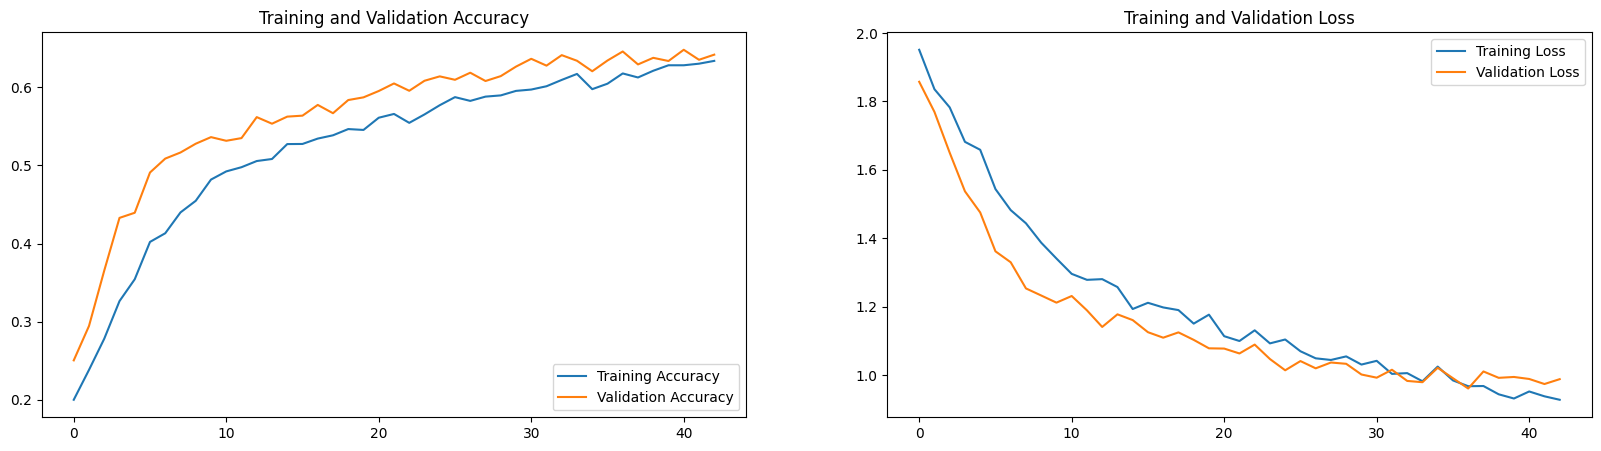

In [ ]:
plot_training_history(train_history)

In [ ]:
import keras

In [ ]:
# model = keras.saving.load_model("/content/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning/ResNet50_Transfer_Learning.keras")

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 19s 171ms/step - loss: 1.0457 - accuracy: 0.6080
final train accuracy = 62.61 , validation accuracy = 60.80


113/113 [==============================] - 20s 171ms/step


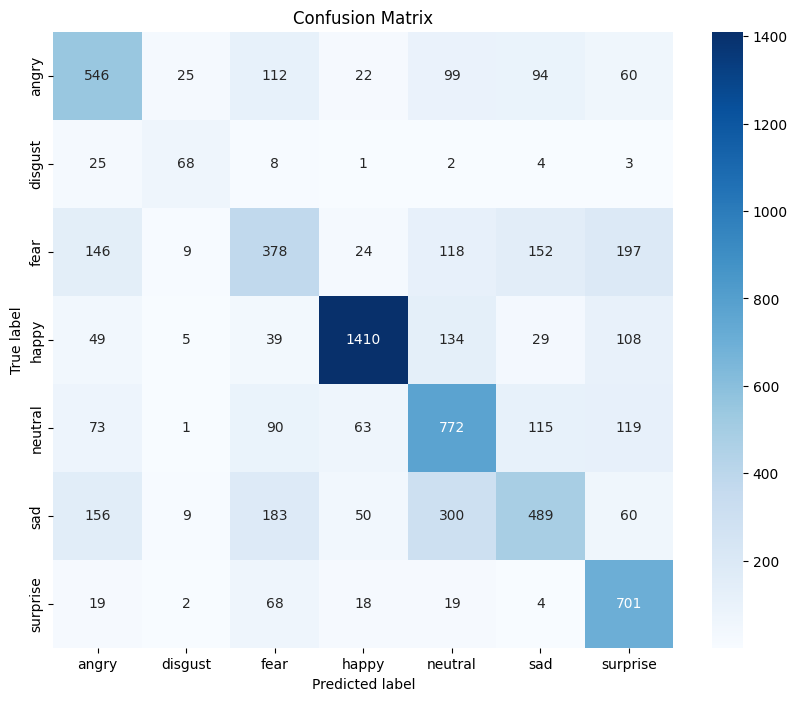

In [ ]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Printing the classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.54      0.57      0.55       958
     disgust       0.57      0.61      0.59       111
        fear       0.43      0.37      0.40      1024
       happy       0.89      0.79      0.84      1774
     neutral       0.53      0.63      0.58      1233
         sad       0.55      0.39      0.46      1247
    surprise       0.56      0.84      0.67       831

    accuracy                           0.61      7178
   macro avg       0.58      0.60      0.58      7178
weighted avg       0.61      0.61      0.60      7178



# continuation

In [ ]:
from tensorflow.keras.metrics import Accuracy,CategoricalAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy

In [ ]:
metrics = [TruePositives(name='tp'),FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
                CategoricalAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]


In [ ]:
# File path for the model checkpoint
cnn_path = '/content/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning'


# Callback to save the model checkpoint

checkpoint_callback = ModelCheckpoint(
    'best_weights',
    monitor='val_accuracy',
    mode = 'max',
    verbose=1,
    save_best_only=True,

    )

# Callback for early stopping
earlystop = EarlyStopping(monitor = 'val_accuracy',
                          patience = 7,
                          restore_best_weights = True,
                          verbose=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=2,
#                             min_lr=0.00005,
                              verbose=1)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
# callbacks = [checkpoint_callback, earlystop, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
# validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [ ]:
test_generator.batch_size

64

In [ ]:
test_steps_epoch

113

# wandb

In [ ]:
pip install wandb==0.15.11


In [ ]:

import wandb

from tensorflow.keras.callbacks import Callback

In [ ]:
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

from wandb.keras import WandbCallback

In [ ]:
# CONFIGURATION = {
#     "BATCH_SIZE": 64,
#     "IM_SIZE": 224,
#     "LEARNING_RATE": 1e-3,
#     "N_EPOCHS": 20,
#     "DROPOUT_RATE": 0.0,
#     "REGULARIZATION_RATE": 0.0,
#     "N_FILTERS": 6,
#     "KERNEL_SIZE": 3,
#     "N_STRIDES": 1,
#     "POOL_SIZE": 2,
#     "N_DENSE_1": 1024,
#     "N_DENSE_2": 128,
#     "NUM_CLASSES": 7,
#     "CLASS_NAMES": ["angry", "happy", "sad"],
# }
# wandb.config = CONFIGURATION


In [ ]:
class_labels = list(test_generator.class_indices.keys())
class_labels

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [ ]:

from keras.models import load_model


import wandb
run = wandb.init(project='ML')
artifact = run.use_artifact('9110161299aj/ML/model-Exp2:v9', type='model')
artifact_dir = artifact.download()


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Downloading large artifact model-Exp2:v9, 292.13MB. 5 files... 
wandb:   5 of 5 files downloaded.  
Done. 0:0:4.1


In [ ]:
# Load the SavedModel
import tensorflow as tf
loaded_model = tf.saved_model.load(artifact_dir)

In [ ]:
keras_model = tf.keras.models.load_model(artifact_dir)

In [ ]:
keras_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                                 
 batch_normalization (Batch  (None, 7, 7, 2048)        8192      
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 64)                6422592   
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                       

In [ ]:
keras_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics,run_eagerly=True)


In [ ]:
from wandb.keras import WandbCallback

# Initialize the WandbCallback
wandb_callback = WandbCallback(
    monitor='val_accuracy',  # Monitor validation accuracy
    save_model='best',  # Save only the best model
    save_model_path='best_model.h5'  # Custom name for the saved model
)

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
class LogConfMatrix(Callback):
  def on_epoch_end(self, epoch, logs):
        true_classes = test_generator.classes
        predicted_classes = np.argmax(keras_model.predict(test_generator, steps=int(np.ceil(test_generator.samples/test_generator.batch_size))), axis=1)
        class_labels = list(test_generator.class_indices.keys())
        try:
            # Compute precision-recall curve
            precision, recall, _ = precision_recall_curve(true_classes, predicted_classes)

            # Plot precision-recall curve
            plt.figure(figsize=(10, 5))
            plt.plot(recall, precision, lw=2)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title('Precision-Recall Curve')
            plt.grid(True)
            plt.legend(loc="best")

            # Log the plot to wandb
            wandb.log({"precision_recall_curve": plt})

            # Show the plot (optional)
            plt.show()
        except Exception as e:
            print("Failed to log precision recall curve: ",e)

        cm = wandb.plot.confusion_matrix(
            y_true=true_classes, preds=predicted_classes, class_names=class_labels
            )


        wandb.log({"conf_mat": cm})





        # Convert true and predicted labels to one-hot encoded format
        y_encoded = pd.get_dummies(true_classes).astype(int).values
        preds_encoded = pd.get_dummies(predicted_classes).astype(int).values

        # Calculate ROC curve and AUC for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(len(class_labels)):
            fpr[i], tpr[i], _ = roc_curve(y_encoded[:, i], preds_encoded[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Plot ROC curves
        plt.figure(figsize=(10, 5))
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
        for i, color in enumerate(colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"ROC curve for {class_labels[i]} (area = {roc_auc[i]:0.2f})")

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')

        # Log the plot to wandb
        wandb.log({"roc_curve": plt})

        # Show the plot (optional)
        plt.show()


In [ ]:
class LogResultsTable(Callback):
    def on_epoch_end(self, epoch, logs):
        columns = ["image", "Predicted", "Label"]
        val_table = wandb.Table(columns=columns)
        class_labels = list(test_generator.class_indices.keys())

        for i in range(25):
            im, label = next(test_generator)

            # Predict the class probabilities for the input image
            predictions = keras_model.predict(im)

            # Get the index of the predicted class with the highest probability
            pred_index = np.argmax(predictions, axis=-1)

            # Convert the predicted index to the corresponding class label
            pred_label = class_labels[pred_index[0]]

            # Convert the true label to the corresponding class label
            true_label_index = np.argmax(label, axis=-1)
            true_label = class_labels[true_label_index[0]]

            row = [wandb.Image(im[0]), pred_label, true_label]
            val_table.add_data(*row)

        wandb.log({"Model Results": val_table})


In [ ]:
callbacks_list = [checkpoint_callback, earlystop, csv_logger,LogConfMatrix(),LogResultsTable(),wandb_callback]

In [ ]:
# Continue training from the loaded model
train_history = keras_model.fit(
    train_generator,
    initial_epoch=22,
    steps_per_epoch=300,
    epochs=50,  # You can continue training for additional epochs
    validation_data=test_generator,
    validation_steps=test_steps_epoch,
    class_weight=class_weights_dict,
    callbacks=callbacks_list
)

Epoch 23/50
300/300 [==============================] - ETA: 0s - loss: 0.9172 - tp: 9756.0000 - fp: 3030.0000 - tn: 112170.0000 - fn: 9444.0000 - accuracy: 0.6467 - precision: 0.7630 - recall: 0.5081 - auc: 0.9201
Epoch 23: val_accuracy did not improve from 0.61034
113/113 [==============================] - 26s 233ms/step
Failed to log precision recall curve:  multiclass format is not supported


/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



300/300 [==============================] - 510s 2s/step - loss: 0.9172 - tp: 9756.0000 - fp: 3030.0000 - tn: 112170.0000 - fn: 9444.0000 - accuracy: 0.6467 - precision: 0.7630 - recall: 0.5081 - auc: 0.9201 - val_loss: 1.1528 - val_tp: 3083.0000 - val_fp: 1206.0000 - val_tn: 41862.0000 - val_fn: 4095.0000 - val_accuracy: 0.5848 - val_precision: 0.7188 - val_recall: 0.4295 - val_auc: 0.8917
Epoch 24/50
300/300 [==============================] - ETA: 0s - loss: 0.8966 - tp: 9850.0000 - fp: 3005.0000 - tn: 112033.0000 - fn: 9323.0000 - accuracy: 0.6498 - precision: 0.7662 - recall: 0.5137 - auc: 0.9226
Epoch 24: val_accuracy improved from 0.61034 to 0.63458, saving model to best_weights
113/113 [==============================] - 27s 235ms/step
Failed to log precision recall curve:  multiclass format is not supported


/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



2/2 [==============================] - 0s 110ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20240515_061810-pswg7kf8/files/model-best)... Done. 1.3s


300/300 [==============================] - 472s 2s/step - loss: 0.8966 - tp: 9850.0000 - fp: 3005.0000 - tn: 112033.0000 - fn: 9323.0000 - accuracy: 0.6498 - precision: 0.7662 - recall: 0.5137 - auc: 0.9226 - val_loss: 1.0143 - val_tp: 3850.0000 - val_fp: 1435.0000 - val_tn: 41633.0000 - val_fn: 3328.0000 - val_accuracy: 0.6346 - val_precision: 0.7285 - val_recall: 0.5364 - val_auc: 0.9159
Epoch 25/50
300/300 [==============================] - ETA: 0s - loss: 0.9264 - tp: 9552.0000 - fp: 3046.0000 - tn: 111992.0000 - fn: 9621.0000 - accuracy: 0.6403 - precision: 0.7582 - recall: 0.4982 - auc: 0.9176
Epoch 25: val_accuracy did not improve from 0.63458
113/113 [==============================] - 24s 215ms/step
Failed to log precision recall curve:  multiclass format is not supported


/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



300/300 [==============================] - 422s 1s/step - loss: 0.9264 - tp: 9552.0000 - fp: 3046.0000 - tn: 111992.0000 - fn: 9621.0000 - accuracy: 0.6403 - precision: 0.7582 - recall: 0.4982 - auc: 0.9176 - val_loss: 1.2210 - val_tp: 3284.0000 - val_fp: 1504.0000 - val_tn: 41564.0000 - val_fn: 3894.0000 - val_accuracy: 0.5755 - val_precision: 0.6859 - val_recall: 0.4575 - val_auc: 0.8856
Epoch 26/50
300/300 [==============================] - ETA: 0s - loss: 0.8801 - tp: 10079.0000 - fp: 2974.0000 - tn: 112064.0000 - fn: 9094.0000 - accuracy: 0.6592 - precision: 0.7722 - recall: 0.5257 - auc: 0.9252
Epoch 26: val_accuracy improved from 0.63458 to 0.64363, saving model to best_weights
113/113 [==============================] - 26s 228ms/step
Failed to log precision recall curve:  multiclass format is not supported


/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



2/2 [==============================] - 0s 100ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20240515_061810-pswg7kf8/files/model-best)... Done. 2.7s


300/300 [==============================] - 471s 2s/step - loss: 0.8801 - tp: 10079.0000 - fp: 2974.0000 - tn: 112064.0000 - fn: 9094.0000 - accuracy: 0.6592 - precision: 0.7722 - recall: 0.5257 - auc: 0.9252 - val_loss: 0.9772 - val_tp: 3769.0000 - val_fp: 1259.0000 - val_tn: 41809.0000 - val_fn: 3409.0000 - val_accuracy: 0.6436 - val_precision: 0.7496 - val_recall: 0.5251 - val_auc: 0.9204
Epoch 27/50
300/300 [==============================] - ETA: 0s - loss: 0.8811 - tp: 10078.0000 - fp: 2981.0000 - tn: 112057.0000 - fn: 9095.0000 - accuracy: 0.6569 - precision: 0.7717 - recall: 0.5256 - auc: 0.9257
Epoch 27: val_accuracy did not improve from 0.64363
113/113 [==============================] - 27s 236ms/step
Failed to log precision recall curve:  multiclass format is not supported


/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



300/300 [==============================] - 424s 1s/step - loss: 0.8811 - tp: 10078.0000 - fp: 2981.0000 - tn: 112057.0000 - fn: 9095.0000 - accuracy: 0.6569 - precision: 0.7717 - recall: 0.5256 - auc: 0.9257 - val_loss: 1.0452 - val_tp: 3645.0000 - val_fp: 1418.0000 - val_tn: 41650.0000 - val_fn: 3533.0000 - val_accuracy: 0.6212 - val_precision: 0.7199 - val_recall: 0.5078 - val_auc: 0.9103
Epoch 28/50
300/300 [==============================] - ETA: 0s - loss: 0.8699 - tp: 10320.0000 - fp: 3078.0000 - tn: 112122.0000 - fn: 8880.0000 - accuracy: 0.6633 - precision: 0.7703 - recall: 0.5375 - auc: 0.9271
Epoch 28: val_accuracy improved from 0.64363 to 0.64475, saving model to best_weights
113/113 [==============================] - 26s 232ms/step
Failed to log precision recall curve:  multiclass format is not supported


/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



2/2 [==============================] - 0s 103ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20240515_061810-pswg7kf8/files/model-best)... Done. 1.3s


300/300 [==============================] - 474s 2s/step - loss: 0.8699 - tp: 10320.0000 - fp: 3078.0000 - tn: 112122.0000 - fn: 8880.0000 - accuracy: 0.6633 - precision: 0.7703 - recall: 0.5375 - auc: 0.9271 - val_loss: 0.9836 - val_tp: 3968.0000 - val_fp: 1432.0000 - val_tn: 41636.0000 - val_fn: 3210.0000 - val_accuracy: 0.6447 - val_precision: 0.7348 - val_recall: 0.5528 - val_auc: 0.9215
Epoch 29/50
300/300 [==============================] - ETA: 0s - loss: 0.8291 - tp: 10585.0000 - fp: 3024.0000 - tn: 112176.0000 - fn: 8615.0000 - accuracy: 0.6709 - precision: 0.7778 - recall: 0.5513 - auc: 0.9320
Epoch 29: val_accuracy did not improve from 0.64475
113/113 [==============================] - 26s 226ms/step
Failed to log precision recall curve:  multiclass format is not supported


/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



300/300 [==============================] - 425s 1s/step - loss: 0.8291 - tp: 10585.0000 - fp: 3024.0000 - tn: 112176.0000 - fn: 8615.0000 - accuracy: 0.6709 - precision: 0.7778 - recall: 0.5513 - auc: 0.9320 - val_loss: 1.0199 - val_tp: 3901.0000 - val_fp: 1453.0000 - val_tn: 41615.0000 - val_fn: 3277.0000 - val_accuracy: 0.6360 - val_precision: 0.7286 - val_recall: 0.5435 - val_auc: 0.9156
Epoch 30/50
300/300 [==============================] - ETA: 0s - loss: 0.8450 - tp: 10501.0000 - fp: 3063.0000 - tn: 111975.0000 - fn: 8672.0000 - accuracy: 0.6719 - precision: 0.7742 - recall: 0.5477 - auc: 0.9299
Epoch 30: val_accuracy did not improve from 0.64475
113/113 [==============================] - 26s 226ms/step
Failed to log precision recall curve:  multiclass format is not supported


/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



300/300 [==============================] - 422s 1s/step - loss: 0.8450 - tp: 10501.0000 - fp: 3063.0000 - tn: 111975.0000 - fn: 8672.0000 - accuracy: 0.6719 - precision: 0.7742 - recall: 0.5477 - auc: 0.9299 - val_loss: 1.0340 - val_tp: 3904.0000 - val_fp: 1491.0000 - val_tn: 41577.0000 - val_fn: 3274.0000 - val_accuracy: 0.6415 - val_precision: 0.7236 - val_recall: 0.5439 - val_auc: 0.9173
Epoch 31/50
300/300 [==============================] - ETA: 0s - loss: 0.8468 - tp: 10474.0000 - fp: 3043.0000 - tn: 112157.0000 - fn: 8726.0000 - accuracy: 0.6696 - precision: 0.7749 - recall: 0.5455 - auc: 0.9298
Epoch 31: val_accuracy did not improve from 0.64475
113/113 [==============================] - 27s 233ms/step
Failed to log precision recall curve:  multiclass format is not supported


/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



300/300 [==============================] - 424s 1s/step - loss: 0.8468 - tp: 10474.0000 - fp: 3043.0000 - tn: 112157.0000 - fn: 8726.0000 - accuracy: 0.6696 - precision: 0.7749 - recall: 0.5455 - auc: 0.9298 - val_loss: 1.2617 - val_tp: 3974.0000 - val_fp: 1607.0000 - val_tn: 41461.0000 - val_fn: 3204.0000 - val_accuracy: 0.6294 - val_precision: 0.7121 - val_recall: 0.5536 - val_auc: 0.9137
Epoch 32/50
300/300 [==============================] - ETA: 0s - loss: 0.8296 - tp: 10631.0000 - fp: 3012.0000 - tn: 112188.0000 - fn: 8569.0000 - accuracy: 0.6753 - precision: 0.7792 - recall: 0.5537 - auc: 0.9326
Epoch 32: val_accuracy improved from 0.64475 to 0.65394, saving model to best_weights
113/113 [==============================] - 27s 237ms/step
Failed to log precision recall curve:  multiclass format is not supported


/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



2/2 [==============================] - 0s 108ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

wandb: Adding directory to artifact (/content/wandb/run-20240515_061810-pswg7kf8/files/model-best)... Done. 1.5s


300/300 [==============================] - 489s 2s/step - loss: 0.8296 - tp: 10631.0000 - fp: 3012.0000 - tn: 112188.0000 - fn: 8569.0000 - accuracy: 0.6753 - precision: 0.7792 - recall: 0.5537 - auc: 0.9326 - val_loss: 0.9747 - val_tp: 3989.0000 - val_fp: 1416.0000 - val_tn: 41652.0000 - val_fn: 3189.0000 - val_accuracy: 0.6539 - val_precision: 0.7380 - val_recall: 0.5557 - val_auc: 0.9217
Epoch 33/50
300/300 [==============================] - ETA: 0s - loss: 0.8323 - tp: 10637.0000 - fp: 2924.0000 - tn: 112114.0000 - fn: 8536.0000 - accuracy: 0.6776 - precision: 0.7844 - recall: 0.5548 - auc: 0.9329
Epoch 33: val_accuracy did not improve from 0.65394
113/113 [==============================] - 26s 230ms/step
Failed to log precision recall curve:  multiclass format is not supported


/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



300/300 [==============================] - 429s 1s/step - loss: 0.8323 - tp: 10637.0000 - fp: 2924.0000 - tn: 112114.0000 - fn: 8536.0000 - accuracy: 0.6776 - precision: 0.7844 - recall: 0.5548 - auc: 0.9329 - val_loss: 0.9826 - val_tp: 4184.0000 - val_fp: 1604.0000 - val_tn: 41464.0000 - val_fn: 2994.0000 - val_accuracy: 0.6520 - val_precision: 0.7229 - val_recall: 0.5829 - val_auc: 0.9237
Epoch 34/50
300/300 [==============================] - ETA: 0s - loss: 0.8116 - tp: 10858.0000 - fp: 3043.0000 - tn: 111995.0000 - fn: 8315.0000 - accuracy: 0.6802 - precision: 0.7811 - recall: 0.5663 - auc: 0.9351
Epoch 34: val_accuracy did not improve from 0.65394
113/113 [==============================] - 26s 229ms/step
Failed to log precision recall curve:  multiclass format is not supported


/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



300/300 [==============================] - 435s 1s/step - loss: 0.8116 - tp: 10858.0000 - fp: 3043.0000 - tn: 111995.0000 - fn: 8315.0000 - accuracy: 0.6802 - precision: 0.7811 - recall: 0.5663 - auc: 0.9351 - val_loss: 0.9658 - val_tp: 4071.0000 - val_fp: 1443.0000 - val_tn: 41625.0000 - val_fn: 3107.0000 - val_accuracy: 0.6505 - val_precision: 0.7383 - val_recall: 0.5671 - val_auc: 0.9248
Epoch 35/50
300/300 [==============================] - ETA: 0s - loss: 0.8355 - tp: 10876.0000 - fp: 2980.0000 - tn: 112058.0000 - fn: 8297.0000 - accuracy: 0.6840 - precision: 0.7849 - recall: 0.5673 - auc: 0.9350
Epoch 35: val_accuracy did not improve from 0.65394
113/113 [==============================] - 27s 241ms/step
Failed to log precision recall curve:  multiclass format is not supported


/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



300/300 [==============================] - 434s 1s/step - loss: 0.8355 - tp: 10876.0000 - fp: 2980.0000 - tn: 112058.0000 - fn: 8297.0000 - accuracy: 0.6840 - precision: 0.7849 - recall: 0.5673 - auc: 0.9350 - val_loss: 1.0644 - val_tp: 3918.0000 - val_fp: 1727.0000 - val_tn: 41341.0000 - val_fn: 3260.0000 - val_accuracy: 0.6226 - val_precision: 0.6941 - val_recall: 0.5458 - val_auc: 0.9126
Epoch 36/50
300/300 [==============================] - ETA: 0s - loss: 0.8355 - tp: 10711.0000 - fp: 3060.0000 - tn: 111978.0000 - fn: 8462.0000 - accuracy: 0.6742 - precision: 0.7778 - recall: 0.5587 - auc: 0.9319
Epoch 36: val_accuracy did not improve from 0.65394
113/113 [==============================] - 26s 232ms/step
Failed to log precision recall curve:  multiclass format is not supported


/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



300/300 [==============================] - 434s 1s/step - loss: 0.8355 - tp: 10711.0000 - fp: 3060.0000 - tn: 111978.0000 - fn: 8462.0000 - accuracy: 0.6742 - precision: 0.7778 - recall: 0.5587 - auc: 0.9319 - val_loss: 1.0103 - val_tp: 3808.0000 - val_fp: 1367.0000 - val_tn: 41701.0000 - val_fn: 3370.0000 - val_accuracy: 0.6346 - val_precision: 0.7358 - val_recall: 0.5305 - val_auc: 0.9168
Epoch 37/50
300/300 [==============================] - ETA: 0s - loss: 0.8041 - tp: 10934.0000 - fp: 2976.0000 - tn: 112062.0000 - fn: 8239.0000 - accuracy: 0.6884 - precision: 0.7861 - recall: 0.5703 - auc: 0.9370
Epoch 37: val_accuracy did not improve from 0.65394
113/113 [==============================] - 27s 240ms/step
Failed to log precision recall curve:  multiclass format is not supported


/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



300/300 [==============================] - 443s 1s/step - loss: 0.8041 - tp: 10934.0000 - fp: 2976.0000 - tn: 112062.0000 - fn: 8239.0000 - accuracy: 0.6884 - precision: 0.7861 - recall: 0.5703 - auc: 0.9370 - val_loss: 1.0297 - val_tp: 3982.0000 - val_fp: 1580.0000 - val_tn: 41488.0000 - val_fn: 3196.0000 - val_accuracy: 0.6362 - val_precision: 0.7159 - val_recall: 0.5548 - val_auc: 0.9158
Epoch 38/50
106/300 [=========>....................] - ETA: 3:49 - loss: 0.7709 - tp: 4012.0000 - fp: 1029.0000 - tn: 39675.0000 - fn: 2772.0000 - accuracy: 0.6975 - precision: 0.7959 - recall: 0.5914 - auc: 0.9402

In [ ]:
def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss.

    Parameters:
    - history: A Keras History object. Contains the logs from the training process.

    Returns:
    - None. Displays the matplotlib plots for training/validation accuracy and loss.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

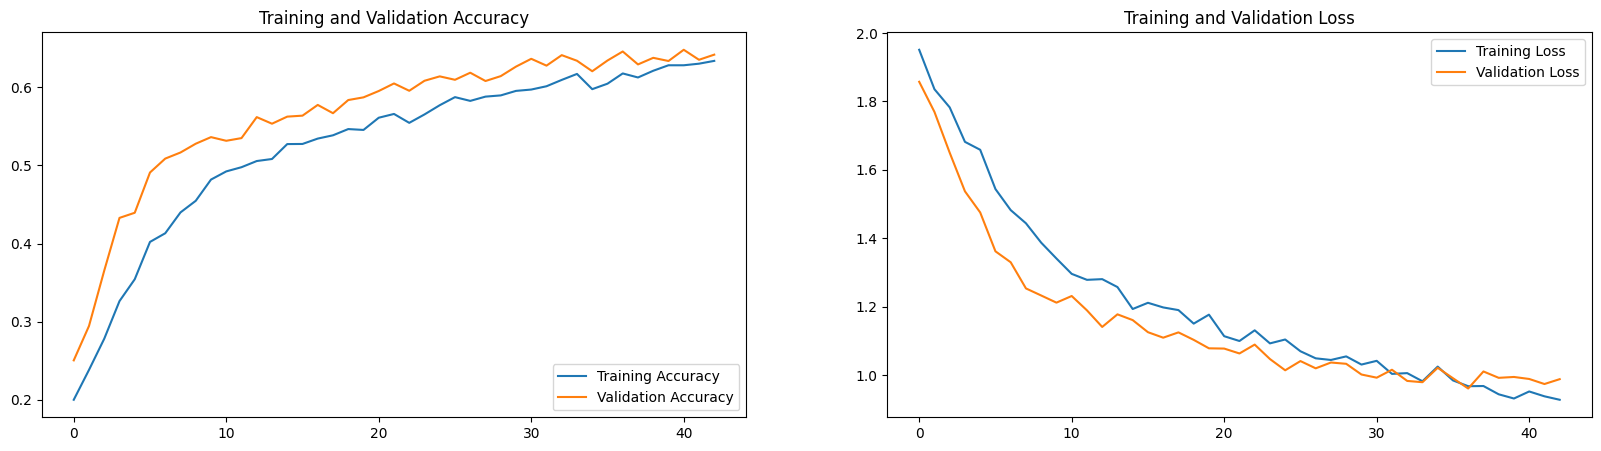

In [ ]:
plot_training_history(train_history)

In [ ]:
import keras

In [ ]:
# model = keras.saving.load_model("/content/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning/ResNet50_Transfer_Learning.keras")

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 19s 171ms/step - loss: 1.0457 - accuracy: 0.6080
final train accuracy = 62.61 , validation accuracy = 60.80


113/113 [==============================] - 20s 171ms/step


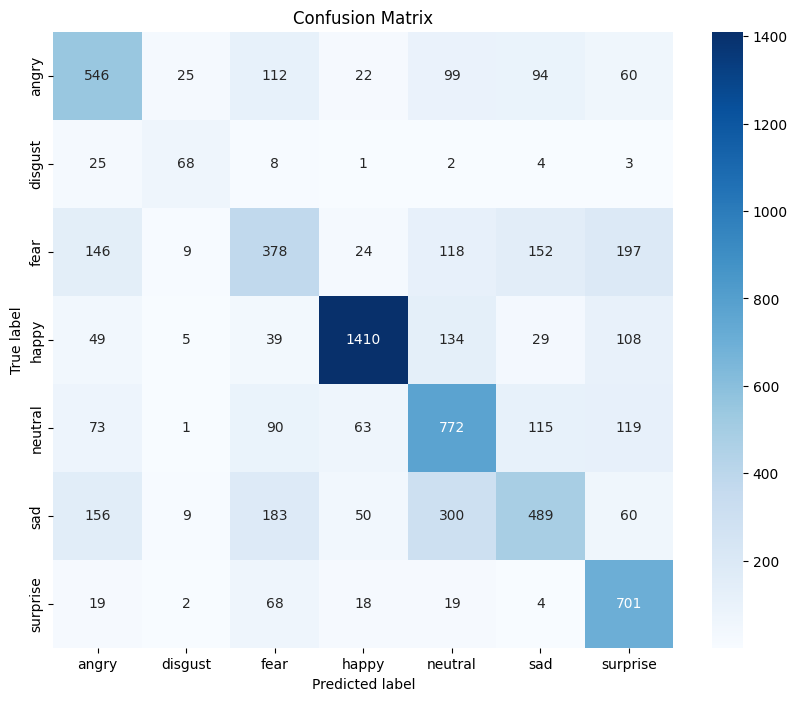

In [ ]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Printing the classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.54      0.57      0.55       958
     disgust       0.57      0.61      0.59       111
        fear       0.43      0.37      0.40      1024
       happy       0.89      0.79      0.84      1774
     neutral       0.53      0.63      0.58      1233
         sad       0.55      0.39      0.46      1247
    surprise       0.56      0.84      0.67       831

    accuracy                           0.61      7178
   macro avg       0.58      0.60      0.58      7178
weighted avg       0.61      0.61      0.60      7178



# AUC ROC plot for each class

In [ ]:
true_labels = test_generator.classes
preds = model.predict(test_generator, steps=len(test_generator))
pred_labels = np.argmax(preds, axis=1)
classes=list(test_generator.class_indices.keys())

113/113 [==============================] - 19s 166ms/step


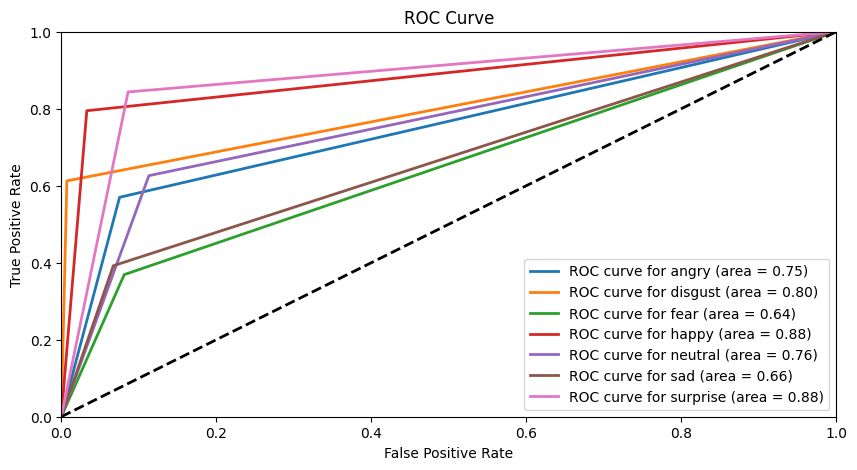

In [ ]:
y_encoded = pd.get_dummies(true_labels).astype(int).values
preds_encoded = pd.get_dummies(pred_labels).astype(int).values

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_encoded[:,i], preds_encoded[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10,5))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"ROC curve for {classes[i]} (area = {roc_auc[i]:0.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

In [ ]:
model.save("Resnet_model_version_2.h5")

# Push all your models into Drive for easy access.

In [ ]:
!cp /content/FER_2013_Emotion_Detection /content/drive/MyDrive/

# Deployement

# Gradio

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip3 install gradio

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import gradio as gr
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image
import cv2
from tensorflow.keras.preprocessing import image

In [ ]:
# Ensure your model is loaded here
# model = ... # Load your trained model
# Load your pre-trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/Emotion_Detection/Final_Resnet50_Best_model.keras')

In [ ]:
# Emotion labels dictionary
emotion_labels = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
index_to_emotion = {v: k for k, v in emotion_labels.items()}
index_to_emotion

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

In [ ]:
def prepare_image(img_pil):
    """Preprocess the PIL image to fit your model's input requirements."""
    # Convert the PIL image to a numpy array with the target size
    img = img_pil.resize((224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Convert single image to a batch.
    img_array /= 255.0  # Rescale pixel values to [0,1], as done during training
    return img_array



# Define the Gradio interface
def predict_emotion(image):
    # Preprocess the image
    processed_image = prepare_image(image)
    # Make prediction using the model
    prediction = model.predict(processed_image)
    # Get the emotion label with the highest probability
    predicted_class = np.argmax(prediction, axis=1)
    predicted_emotion = index_to_emotion.get(predicted_class[0], "Unknown Emotion")
    return predicted_emotion

interface = gr.Interface(
    fn=predict_emotion,  # Your prediction function
    inputs=gr.Image(type="pil"),  # Input for uploading an image, directly compatible with PIL images
    outputs="text",  # Output as text displaying the predicted emotion
    title="Emotion Detection",
    description="Upload an image and see the predicted emotion."
)

# Launch the Gradio interface
interface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://eb53f8c30e2eca7f49.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
